# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
---

---

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import math
import os
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

## Load the images from the directory


In [14]:
image_list = []

os.listdir("test_images/")
path = "test_images/"

#load the images into a list of arrays
for file in os.listdir(path):
    img = mpimg.imread(os.path.join(path, file))
    image_list.append(img)

def printimg (images, cmap =None):
    col = 2
    row = len(images) +1 // 2 
    plt.figure(figsize=(10,20))
    for i, image in enumerate(images):
        plt.subplot(row,col,i+1)
        cmap = 'gray' if len(image.shape)==2 else cmap
        plt.imshow(image, cmap)
        plt.xticks([])
        plt.yticks([])
    plt.tight_layout(pad=0, h_pad=0, w_pad=0)
    plt.show()

### Color Selection
The lane markings are strictly in White or Yellow and hence we need to filter out only the pixels which are white or yellow.

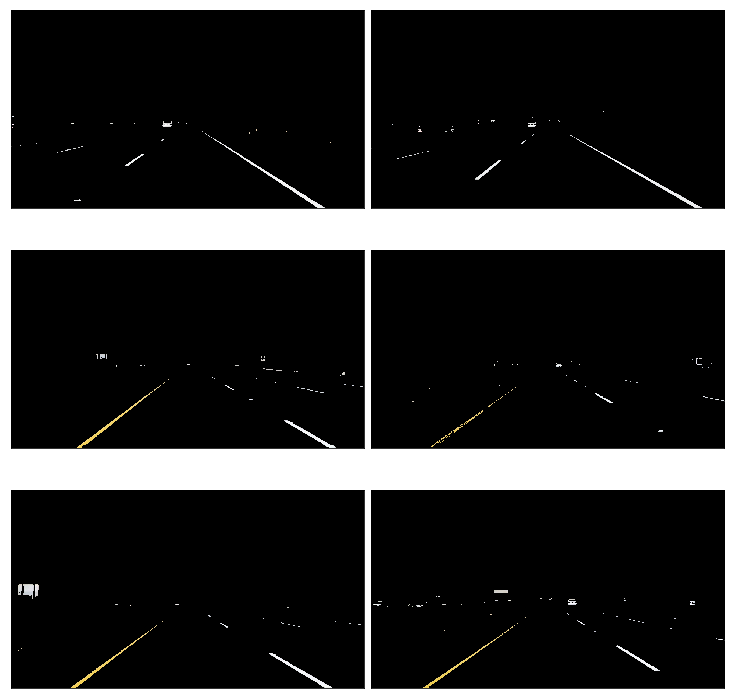

In [3]:
def colorSelect(img):
    # create a mask for white
    lower_white = np.array([195, 195, 195])
    upper_white = np.array([255, 255, 255])
    white_mask = cv2.inRange(img, lower_white, upper_white)
    # create a mask for yellow
    lower_yellow = np.array([200, 200, 0])
    upper_yellow = np.array([255, 255, 200])
    yellow_mask = cv2.inRange(img, lower_yellow, upper_yellow)
    
    mask = cv2.bitwise_or(white_mask, yellow_mask)
    return cv2.bitwise_and(img, img, mask = mask)

col_filt_list = list(map(colorSelect, image_list))
printimg(col_filt_list)

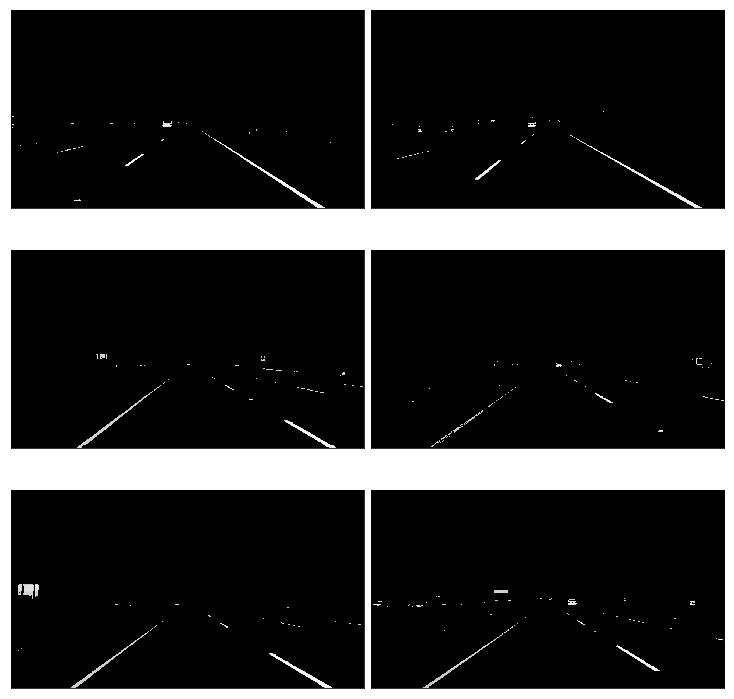

In [4]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

gray_list = list(map(grayscale, col_filt_list))
printimg(gray_list)

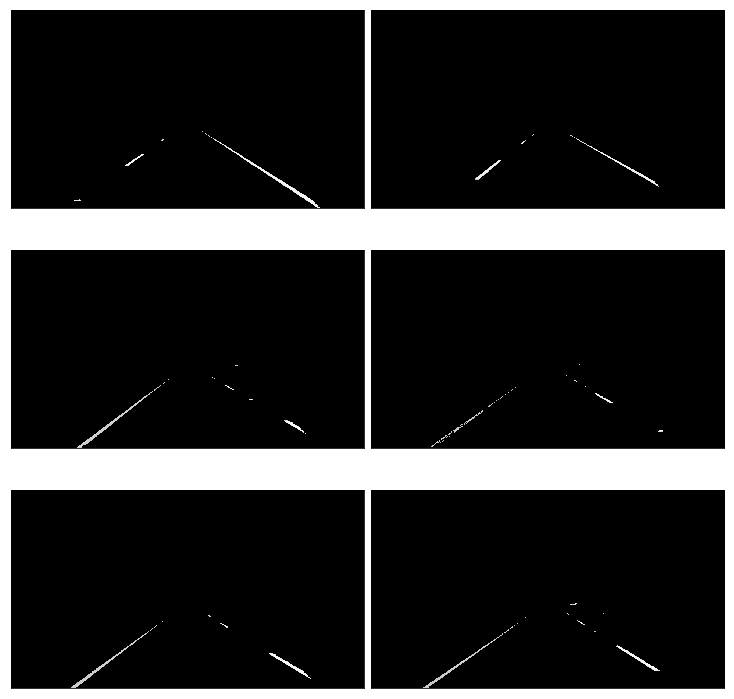

In [5]:
def region_of_interest(img):
    
    vertices = np.array([[(100,550),(380, 350), (600, 300), (850,550)]], dtype=np.int32)
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

roi_list = list(map(region_of_interest, gray_list))
printimg(roi_list)

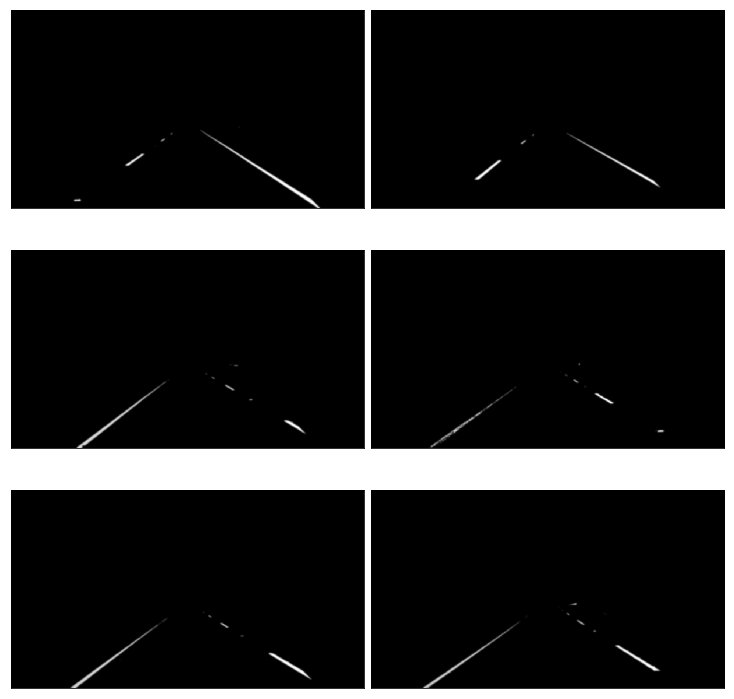

In [6]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

kernel_size = 9

blur_list = list(map(lambda image: gaussian_blur(image, kernel_size), roi_list))
printimg(blur_list)

### Edge Detection

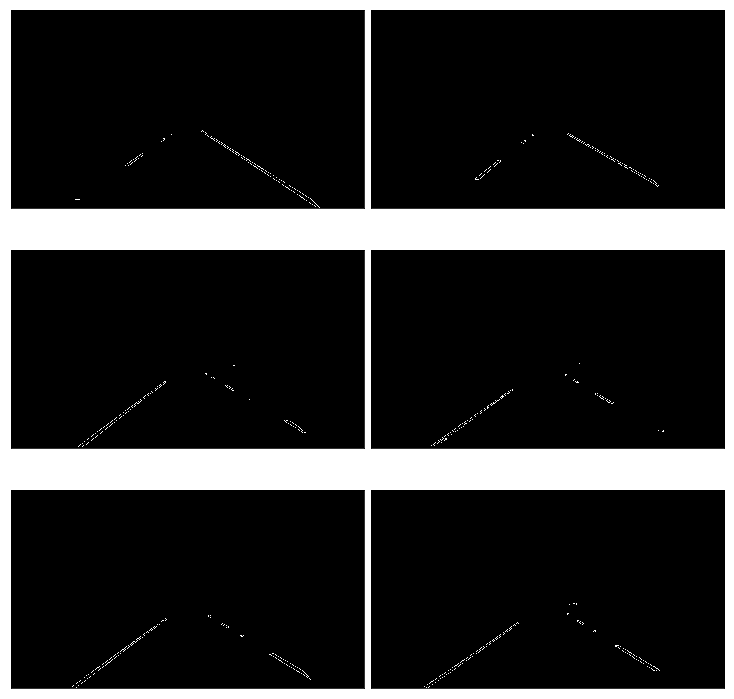

In [7]:
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

low_threshold = 50
high_threshold = 150

edge_list = list(map(lambda image: canny(image, low_threshold, high_threshold), blur_list))

printimg(edge_list)

### Line Extraction

In [8]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines

# Define the Hough transform parameters
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/90 # angular resolution in radians of the Hough grid
threshold = 30     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 30 #minimum number of pixels making up a line
max_line_gap = 500    # maximum gap in pixels between connectable line segments


line_list = list(map(lambda image: hough_lines(image, rho, theta, threshold, min_line_len, max_line_gap), edge_list))


### Draw Lines 
*** Stuck here. Need help with the lambda function ***

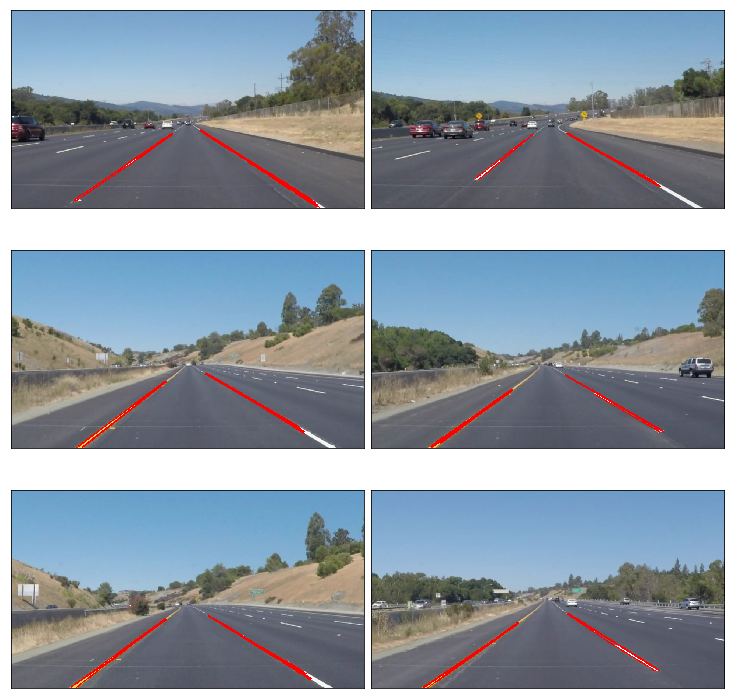

In [15]:
def draw_lines(image, lines, color=[255, 0, 0], thickness=2):
    # the lines returned by cv2.HoughLinesP has the shape (-1, 1, 4)
    
    new_image = np.copy(image) # don't want to modify the original
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(new_image, (x1, y1), (x2, y2), color, thickness)
    return new_image


line_img_list = []

for img, line in zip(image_list, line_list):
    line_img_list.append(draw_lines(img, line))

printimg(line_img_list)    
    
                 


In [ ]:
def lane_lines(lines):
    for line in lines:
        m = (y1 - y2) / (x1 - x2)
